# Pretrain results summary

This notebook pulls specific W&B runs and compiles requested metrics into a table.

In [15]:
# Configuration for target project and runs
PROJECT = "melinajingting-ucl/foundational_ssm_pretrain"
RUN_NAMES = [
    "l2_reaching",
    "l2_reaching_1Swindow",
    "l2_no_context_reaching",
    "l2_no_glu_reaching",
]
DATASETS = [
    "pm_c_co", "pm_c_rt", "pm_m_co", "pm_m_rt",
    "os_l_rt", "os_i_rt", "cs_j_co", "cs_n_co",
]

# Metric keys to collect
ALL_KEY = "val/r2/all"
MEAN_KEY = "val/r2/{ds}/mean"
STD_KEY = "val/r2/{ds}/std"

In [16]:
import os
import pandas as pd
import wandb

# Optional: set W&B API key from env var if available (WANDB_API_KEY)
api_key = os.environ.get("WANDB_API_KEY")
if api_key:
    os.environ["WANDB_API_KEY"] = api_key

api = wandb.Api()

# Helper to safely extract nested config or summary keys

def get_summary_value(run, key):
    try:
        return run.summary.get(key, None)
    except Exception:
        return None

rows = []
for name in RUN_NAMES:
    # Select by run display name; if duplicate names exist, take the latest finished
    runs = api.runs(PROJECT, filters={"display_name": name})
    run = None
    if runs:
        # Prefer finished runs; else take the first
        finished = [r for r in runs if r.state == "finished"]
        run = finished[0] if finished else runs[0]
    if run is None:
        rows.append({"run": name, "error": "not found"})
        continue

    row = {"run": name}
    # All metric
    row[ALL_KEY] = get_summary_value(run, ALL_KEY)
    # Dataset metrics
    for ds in DATASETS:
        row[MEAN_KEY.format(ds=ds)] = get_summary_value(run, MEAN_KEY.format(ds=ds))
        row[STD_KEY.format(ds=ds)] = get_summary_value(run, STD_KEY.format(ds=ds))

    rows.append(row)

results_df = pd.DataFrame(rows)
# Order columns: run, all, then dataset means/stds in requested order
cols = ["run", ALL_KEY]
for ds in DATASETS:
    cols += [MEAN_KEY.format(ds=ds), STD_KEY.format(ds=ds)]
results_df = results_df.reindex(columns=cols)
results_df

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


,run,val/r2/all,val/r2/pm_c_co/mean,val/r2/pm_c_co/std,val/r2/pm_c_rt/mean,val/r2/pm_c_rt/std,val/r2/pm_m_co/mean,val/r2/pm_m_co/std,val/r2/pm_m_rt/mean,val/r2/pm_m_rt/std,val/r2/os_l_rt/mean,val/r2/os_l_rt/std,val/r2/os_i_rt/mean,val/r2/os_i_rt/std,val/r2/cs_j_co/mean,val/r2/cs_j_co/std,val/r2/cs_n_co/mean,val/r2/cs_n_co/std
0,l2_reaching,0.869369,0.869547,0.039345,0.719978,0.058649,0.841416,0.030985,0.747371,0.068327,0.656166,0.045337,0.684675,0.063418,0.916892,0.008413,0.942940,0.010496
1,l2_reaching_1Swindow,0.872704,0.868631,0.038440,0.737240,0.049569,0.845489,0.034651,0.759992,0.064539,0.651308,0.051019,0.701572,0.068266,0.915574,0.009107,0.943298,0.009414
2,l2_no_context_reaching,0.871864,0.867724,0.041115,0.730771,0.047371,0.845201,0.035952,0.749172,0.034526,0.654073,0.047676,0.696354,0.058391,0.918690,0.006911,0.942297,0.009733
3,l2_no_glu_reaching,0.850661,0.836942,0.043231,0.711011,0.048492,0.816230,0.036371,0.758417,0.040011,0.639950,0.048244,0.657902,0.060449,0.909406,0.003798,0.934939,0.014088


In [17]:
# Display with better precision
pd.set_option("display.precision", 4)
results_df.style.format(precision=4)

# Optional: save to CSV next to notebook
out_path = "results/pretrain_results_summary.csv"
try:
    results_df.to_csv(out_path, index=False)
    print(f"Saved CSV to {out_path}")
except Exception as e:
    print(f"Could not save CSV: {e}")

Saved CSV to results/pretrain_results_summary.csv


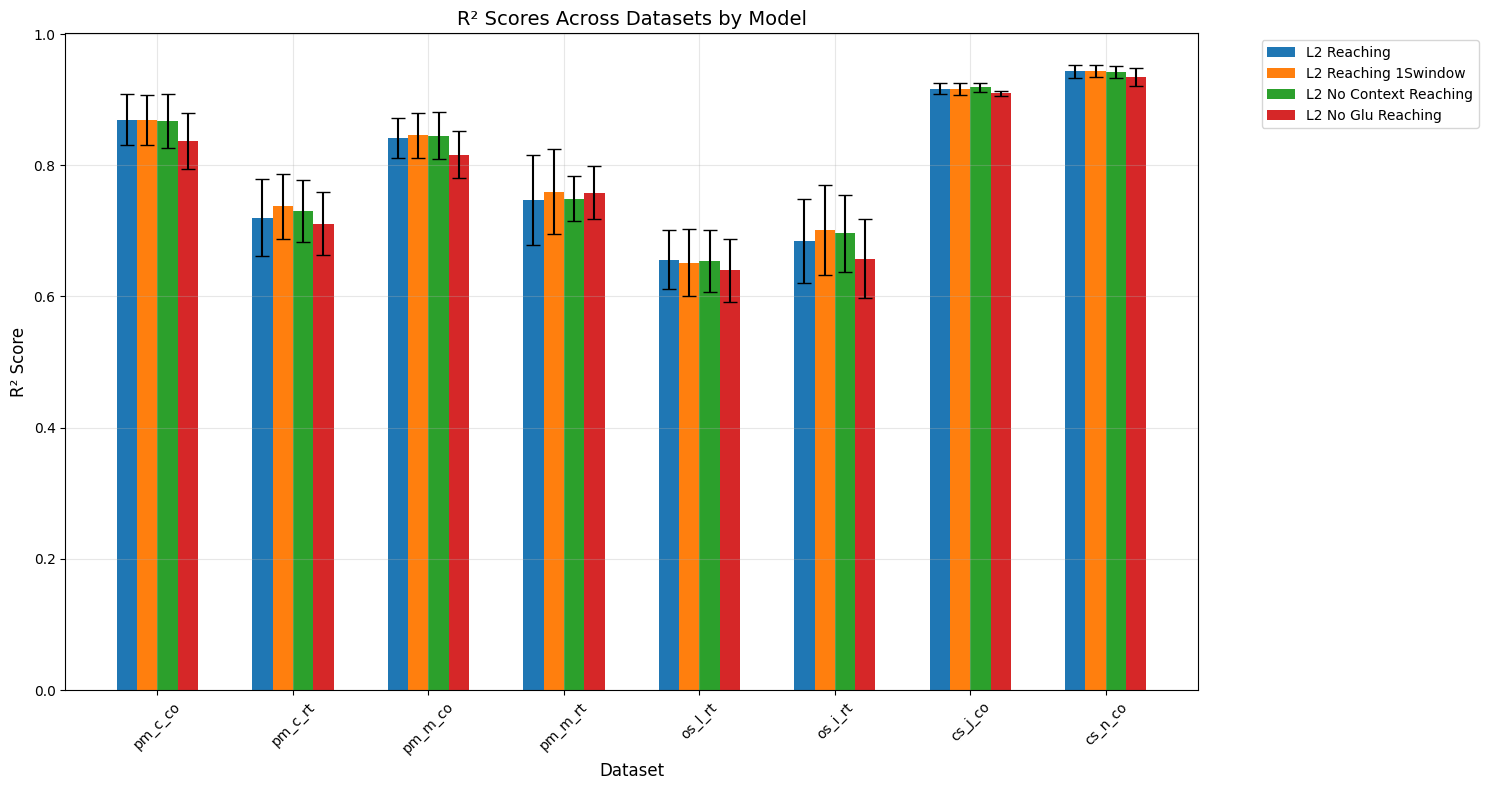

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure size for better readability
plt.figure(figsize=(15, 8))

# Set up positions for bars
x = np.arange(len(DATASETS))
width = 0.15  # Width of bars
offsets = [-1.5, -0.5, 0.5, 1.5]  # Offsets for different runs

# Plot bars for each run
for i, run_name in enumerate(RUN_NAMES):
    run_data = results_df[results_df['run'] == run_name].iloc[0]
    
    # Get means and stds for this run
    means = [run_data[f'val/r2/{ds}/mean'] for ds in DATASETS]
    stds = [run_data[f'val/r2/{ds}/std'] for ds in DATASETS]
    
    # Plot bars with error bars
    plt.bar(x + width * offsets[i], means, width, 
            label=run_name.replace('_', ' ').title(),
            capsize=5, yerr=stds)

# Customize plot
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('R² Scores Across Datasets by Model', fontsize=14)
plt.xticks(x, DATASETS, rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

## Downstream sweep results (wandb: foundational_ssm_downstream_sweep)

Fetch finished runs, extract `final/r2/*/mean`, aggregate per dataset/task across configurations, and plot comparisons.

In [25]:
# Fetch downstream sweep runs and extract final metrics
import re
from collections import defaultdict

DOWNSTREAM_PROJECT = "melinajingting-ucl/foundational_ssm_downstream_sweep"

api = wandb.Api()
runs = api.runs(DOWNSTREAM_PROJECT, filters={"state": "finished"})

records = []
for r in runs:
    cfg = r.config or {}
    # Extract sweep origin if present
    sweep_name = r.sweep.name if getattr(r, "sweep", None) else None
    # Find all final/r2/*/mean in summary
    for k, v in r.summary.items():
        if isinstance(k, str) and k.startswith("final/r2/") and k.endswith("/mean"):
            dataset = k[len("final/r2/"):-len("/mean")]
            records.append({
                "run_id": r.id,
                "run_name": r.display_name,
                "sweep": sweep_name,
                "dataset": dataset,
                "r2": v,
                # Key config axes for comparisons
                "from_scratch": cfg.get("training.from_scratch"),
                "opt_mode": cfg.get("optimizer.mode"),  # all vs encoder_only
                "checkpoint": cfg.get("model.checkpoint"),
                "dataset_name": cfg.get("dataset.name") or cfg.get("dataset_args.recording_id"),
            })

downstream_df = pd.DataFrame.from_records(records)
downstream_df.head()

,run_id,run_name,sweep,dataset,r2,from_scratch,opt_mode,checkpoint,dataset_name
0,koxc3s3i,scratch_l2_reaching_mc_rtt_prepend_all,official_transfer_sweep_2sep,mc_rtt_prepend,0.7426,True,all,melinajingting-ucl/foundational_ssm_pretrain/l...,mc_rtt_prepend
1,gigzarb9,finetuned_l2_reaching_mc_rtt_prepend_all,official_transfer_sweep_2sep,mc_rtt_prepend,0.7568,False,all,melinajingting-ucl/foundational_ssm_pretrain/l...,mc_rtt_prepend
2,jjtyfpud,scratch_l2_reaching_mc_rtt_prepend_encoder_only,official_transfer_sweep_2sep,mc_rtt_prepend,0.0113,True,encoder_only,melinajingting-ucl/foundational_ssm_pretrain/l...,mc_rtt_prepend
3,bh9j06qf,finetuned_l2_reaching_mc_rtt_prepend_encoder_only,official_transfer_sweep_2sep,mc_rtt_prepend,0.0576,False,encoder_only,melinajingting-ucl/foundational_ssm_pretrain/l...,mc_rtt_prepend
4,jzbavaqw,scratch_l2_reaching_1Swindow_mc_rtt_prepend_all,official_transfer_sweep_2sep,mc_rtt_prepend,0.7426,True,all,melinajingting-ucl/foundational_ssm_pretrain/l...,mc_rtt_prepend


In [32]:
# Identify PM vs NLB datasets and compute aggregates for PM tasks

def is_pm(dataset: str) -> bool:
    return isinstance(dataset, str) and (dataset.startswith("pm_") or "perich_miller" in dataset or dataset.startswith("t_"))


def pm_task_from_dataset(ds: str) -> str:
    # Handle multiple naming styles:
    # - pm_* suffixes: *_co -> center_out, *_rt -> random_target
    # - recording ids like t_YYYYMMDD_center_out_reaching / random_target_reaching
    if not isinstance(ds, str):
        return "unknown"
    if ds.endswith("_co") or "center_out" in ds:
        return "pm_center_out"
    if ds.endswith("_rt") or "random_target" in ds:
        return "pm_random_target"
    return ds  # fallback to original label

# Build a tidy base dataframe per run/dataset with a derived task column
plot_df = downstream_df.copy()
plot_df["is_pm"] = plot_df["dataset"].apply(is_pm)
plot_df["task"] = plot_df.apply(
    lambda x: pm_task_from_dataset(x["dataset"]) if x["is_pm"] else x["dataset"], axis=1
)

# Friendly labels for plotting
plot_df["train_mode"] = plot_df["from_scratch"].map({True: "scratch", False: "finetune"}).fillna("unknown")
plot_df["checkpoint_short"] = plot_df["checkpoint"].apply(
    lambda s: s.split("/")[-1].split(":")[0] if isinstance(s, str) else s
)

# Aggregated (mean/std) per (checkpoint, train_mode, opt_mode, task)
agg_cols = ["checkpoint_short", "train_mode", "opt_mode", "task"]
pm_agg = (
    plot_df[plot_df["is_pm"]]
    .groupby(agg_cols)
    .agg(r2_mean=("r2", "mean"), r2_std=("r2", "std"), n=("r2", "count"))
    .reset_index()
)

nlb_agg = (
    plot_df[~plot_df["is_pm"]]
    .groupby(agg_cols)
    .agg(r2_mean=("r2", "mean"), r2_std=("r2", "std"), n=("r2", "count"))
    .reset_index()
)

agg_df = pd.concat([pm_agg, nlb_agg], ignore_index=True, sort=False)
agg_df.head()

,checkpoint_short,train_mode,opt_mode,task,r2_mean,r2_std,n
0,l2_reaching_checkpoint,finetune,encoder_only,pm_center_out,0.6368,NaN,1
1,l2_reaching_checkpoint,scratch,all,pm_center_out,0.8081,NaN,1
2,l2_reaching_checkpoint,scratch,encoder_only,pm_center_out,0.2291,NaN,1
3,l2_no_context_reaching_checkpoint,scratch,all,mc_area2bump_prepend,0.7779,NaN,1
4,l2_no_context_reaching_checkpoint,scratch,all,mc_rtt_prepend,0.7544,NaN,1


In [ ]:
# Utility: compare best-per-task across a category with filters, plot + tables
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def compare_best_by_category(
    df: pd.DataFrame,
    category_col: str,
    filter_by: dict | None = None,
    value_col: str = "r2_mean",
    err_col: str | None = "r2_std",
    task_col: str = "task",
    annotate_col: str | None = "checkpoint_short",
    title: str | None = None,
    figsize=(14, 7),
    save_csv_path: str | None = None,
    # New controls
    show_annotations: bool = False,
    group_sep: float = 1.6,          # spacing between different datasets/tasks (>= 1)
    intra_group_scale: float = 0.9,  # how close bars are within a dataset (<= 1 tighter)
    bar_alpha: float = 0.95,
):
    """
    Filter df, pick the best row (max value_col) per (task, category), plot grouped bars with error bars,
    and display summary tables.

    Args:
      df: aggregated dataframe (e.g., agg_df)
      category_col: column to compare (e.g., 'train_mode', 'checkpoint_short')
      filter_by: dict of equality filters, e.g., {'opt_mode': 'all', 'train_mode': 'finetune'}
      value_col: metric mean column (default r2_mean)
      err_col: metric std column (default r2_std, can be None)
      task_col: column containing task/dataset label (default 'task')
      annotate_col: column to annotate on bars. Ignored unless show_annotations=True.
      title: plot title; if None, auto-generates
      figsize: figure size
      save_csv_path: if provided, saves the best table to CSV
      show_annotations: whether to draw vertical text annotations atop bars
      group_sep: spacing between dataset groups (centers); larger => groups further apart
      intra_group_scale: multiplier controlling within-group bar offsets; smaller => closer bars
      bar_alpha: bar transparency

    Returns:
      best_df: long-form table of best rows per (task, category)
      wide_mean: pivot of means (tasks x category)
      wide_std: pivot of stds (tasks x category) if err_col provided
    """
    sub = df.copy()
    if filter_by:
        for k, v in filter_by.items():
            if k not in sub.columns:
                continue
            if isinstance(v, (list, tuple, set)):
                sub = sub[sub[k].isin(list(v))]
            else:
                sub = sub[sub[k].astype(str) == str(v)]

    if sub.empty:
        print("No rows match filters:", filter_by)
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    # Pick best per (task, category)
    grp_cols = [task_col, category_col]
    try:
        best_idx = sub.groupby(grp_cols, dropna=False)[value_col].idxmax()
    except Exception as e:
        print("Failed to group/select best:", e)
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    best_df = sub.loc[best_idx].copy().reset_index(drop=True)

    # Determine plotting order
    task_order = sorted(best_df[task_col].astype(str).unique())
    cat_order = [c for c in sorted(best_df[category_col].astype(str).unique())]

    # Build matrices
    mean_mat = (
        best_df.pivot(index=task_col, columns=category_col, values=value_col)
        .reindex(index=task_order, columns=cat_order)
    )
    std_mat = (
        best_df.pivot(index=task_col, columns=category_col, values=err_col)
        .reindex(index=task_order, columns=cat_order)
        if err_col and err_col in best_df.columns
        else None
    )
    ann_mat = (
        best_df.pivot(index=task_col, columns=category_col, values=annotate_col)
        .reindex(index=task_order, columns=cat_order)
        if annotate_col and annotate_col in best_df.columns
        else None
    )

    # Plot: grouped bars per task with custom spacing
    sns.set(style="whitegrid")
    x = np.arange(len(task_order)) * float(group_sep)
    C = max(len(cat_order), 1)
    width = min(0.7 / C, 0.26)
    offsets = (np.arange(C) - (C - 1) / 2.0) * (width * intra_group_scale)

    plt.figure(figsize=figsize)
    for i, cat in enumerate(cat_order):
        y = mean_mat[cat].values
        yerr = std_mat[cat].values if std_mat is not None and cat in std_mat.columns else None
        plt.bar(x + offsets[i], y, width=width, yerr=yerr, capsize=4, alpha=bar_alpha, label=str(cat))

    # Optional annotations (disabled by default)
    if show_annotations and ann_mat is not None:
        for i, cat in enumerate(cat_order):
            for j, _t in enumerate(task_order):
                ann = ann_mat.iloc[j, i]
                val = mean_mat.iloc[j, i]
                err = std_mat.iloc[j, i] if std_mat is not None else 0
                if isinstance(ann, str) and pd.notna(val):
                    try:
                        top = float(val) + (float(err) if (err is not None and pd.notna(err)) else 0)
                        plt.text(x[j] + offsets[i], top + 0.01, ann, ha="center", va="bottom", fontsize=8, rotation=90)
                    except Exception:
                        pass

    plt.xticks(x, task_order, rotation=30)
    plt.ylabel("R² (best mean ± std)")
    if title is None:
        title = f"Best {value_col} per {task_col} by {category_col}"
        if filter_by:
            title += " | " + ", ".join(f"{k}={v}" for k, v in filter_by.items())
    plt.title(title)
    plt.legend(title=category_col)
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Tables to display/return (avoid duplicate column labels)
    select_cols = [task_col, category_col, value_col]
    if err_col and err_col not in select_cols:
        select_cols.append(err_col)

    ann_out_col = None
    if annotate_col:
        if annotate_col not in select_cols:
            select_cols.append(annotate_col)
            ann_out_col = annotate_col
        elif annotate_col == category_col:
            ann_out_col = f"{annotate_col}_annot"
            best_df[ann_out_col] = best_df[annotate_col]
            select_cols.append(ann_out_col)

    sort_keys = list(dict.fromkeys([task_col, category_col]))
    best_display = best_df[select_cols].sort_values(sort_keys)

    wide_mean = mean_mat.copy()
    wide_std = std_mat.copy() if std_mat is not None else pd.DataFrame()

    if save_csv_path:
        try:
            best_display.to_csv(save_csv_path, index=False)
            print(f"Saved table to {save_csv_path}")
        except Exception as e:
            print("Could not save CSV:", e)

    display(best_display)
    display(wide_mean)
    if not wide_std.empty:
        display(wide_std)

    return best_display, wide_mean, wide_std

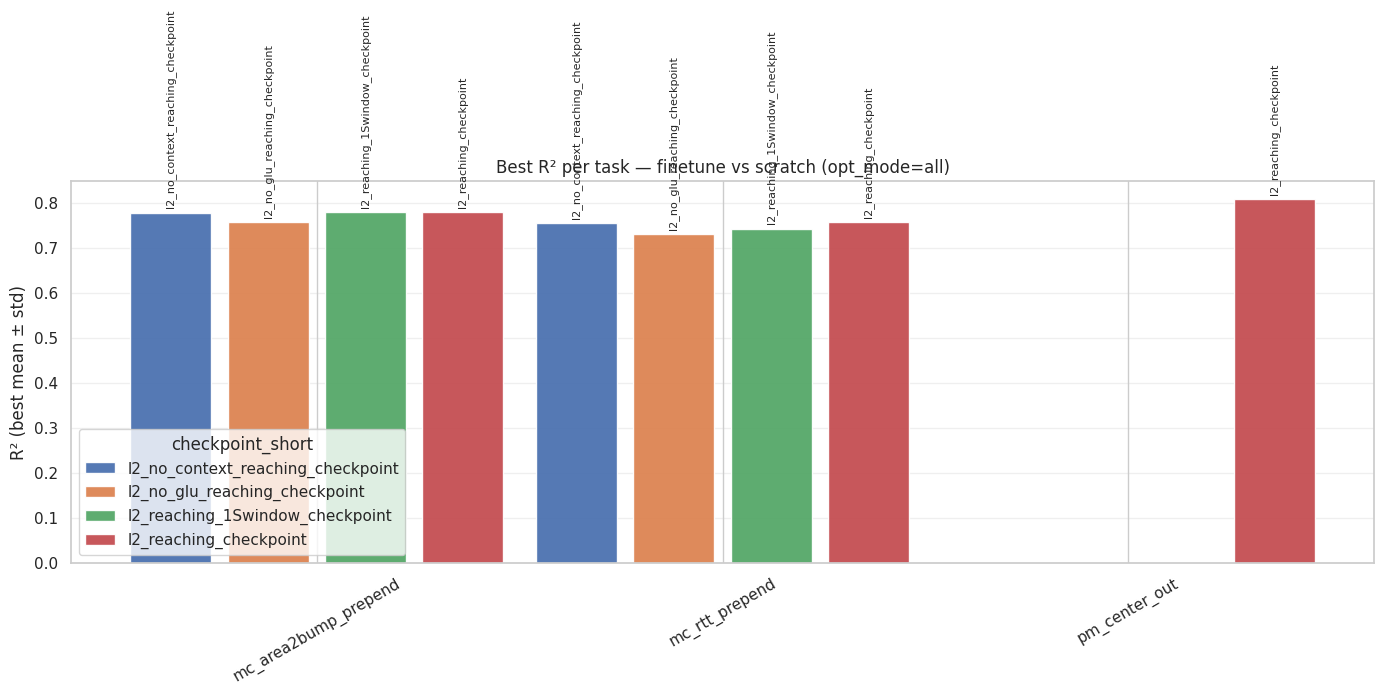

ValueError: The column label 'checkpoint_short' is not unique.

In [ ]:
# Example: Best finetune vs scratch when opt_mode == 'all', grouped by train_mode
best_tbl, mean_pivot, std_pivot = compare_best_by_category(
    df=agg_df,
    category_col="train_mode",          # compare finetune vs scratch
    filter_by={"opt_mode": "all"},      # filter to optimizer mode 'all'
    value_col="r2_mean",
    err_col="r2_std",
    task_col="task",
    annotate_col="checkpoint_short",     # available but hidden unless show_annotations=True
    title="Best R² per task — finetune vs scratch (opt_mode=all)",
    save_csv_path="results/best_finetune_vs_scratch_opt_all.csv",
    show_annotations=False,
    group_sep=1.8,            # farther apart across datasets
    intra_group_scale=0.7,    # closer bars within each dataset
)

# Another example: compare checkpoints under finetune only
# best_tbl_ckpt, mean_pivot_ckpt, std_pivot_ckpt = compare_best_by_category(
#     df=agg_df,
#     category_col="checkpoint_short",
#     filter_by={"opt_mode": "all", "train_mode": "finetune"},
#     annotate_col=None,
#     title="Best R² per task — checkpoints (finetune, opt_mode=all)",
#     save_csv_path="results/best_checkpoints_finetune_opt_all.csv",
#     show_annotations=False,
#     group_sep=1.8,
#     intra_group_scale=0.7,
# )

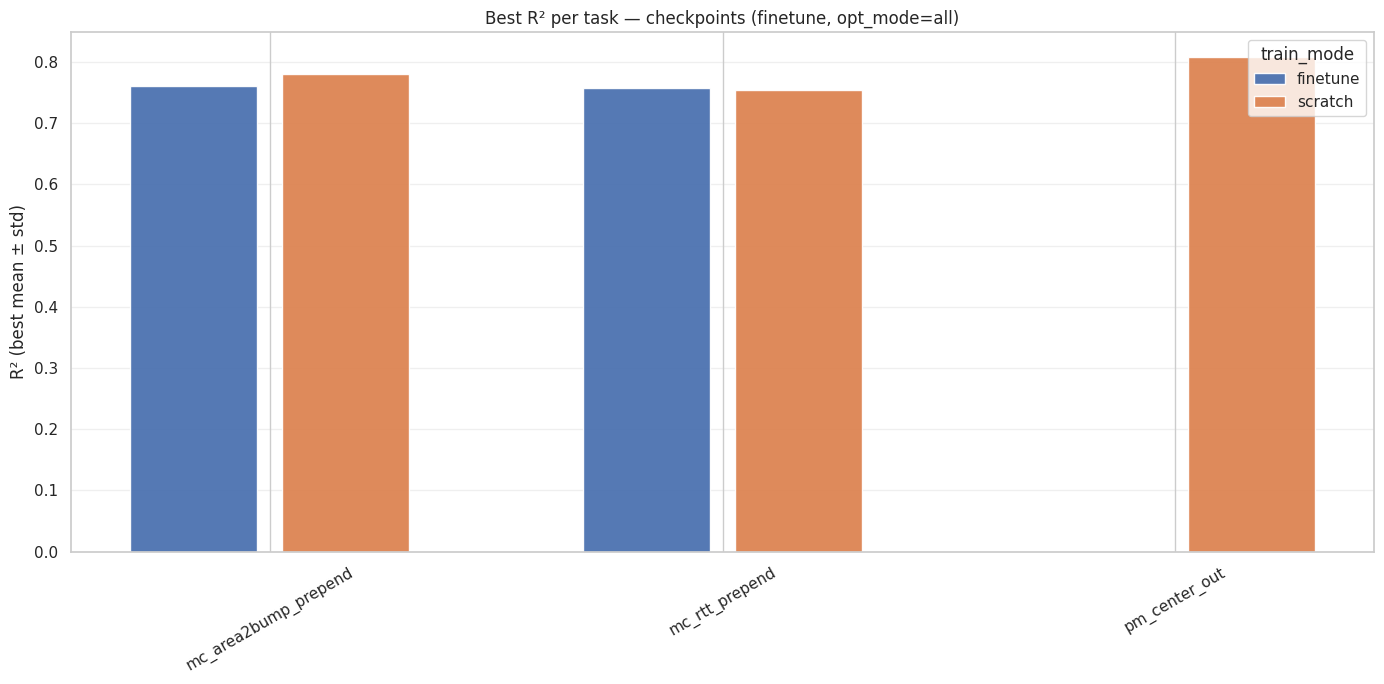

Saved table to results/best_checkpoints_finetune_opt_all.csv


,task,train_mode,r2_mean,r2_std
0,mc_area2bump_prepend,finetune,0.7601,NaN
1,mc_area2bump_prepend,scratch,0.7797,NaN
2,mc_rtt_prepend,finetune,0.7568,NaN
3,mc_rtt_prepend,scratch,0.7544,NaN
4,pm_center_out,scratch,0.8081,NaN


train_mode,finetune,scratch
task,,
mc_area2bump_prepend,0.7601,0.7797
mc_rtt_prepend,0.7568,0.7544
pm_center_out,NaN,0.8081


train_mode,finetune,scratch
task,,
mc_area2bump_prepend,NaN,NaN
mc_rtt_prepend,NaN,NaN
pm_center_out,NaN,NaN


In [38]:
best_tbl_ckpt, mean_pivot_ckpt, std_pivot_ckpt = compare_best_by_category(
    df=agg_df,
    category_col="train_mode",
    filter_by={"opt_mode": "all", },
    annotate_col=None,
    title="Best R² per task — checkpoints (finetune, opt_mode=all)",
    save_csv_path="results/best_checkpoints_finetune_opt_all.csv",
)